In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import glob
import cPickle as cp
import hera_cal
import aipy
from astropy.time import Time
import astropy
import astropy.units as u

# Gain variation with time

How the gains vary with time directly affects how frequently you have to calibrate the antennas. 

If you calibrate only a subset of baselines you need to calibrate for longer to acheive the same SNR. But if the gain variations on short scales are high, the integration will wash out the structure.

<IPython.core.display.Javascript object>


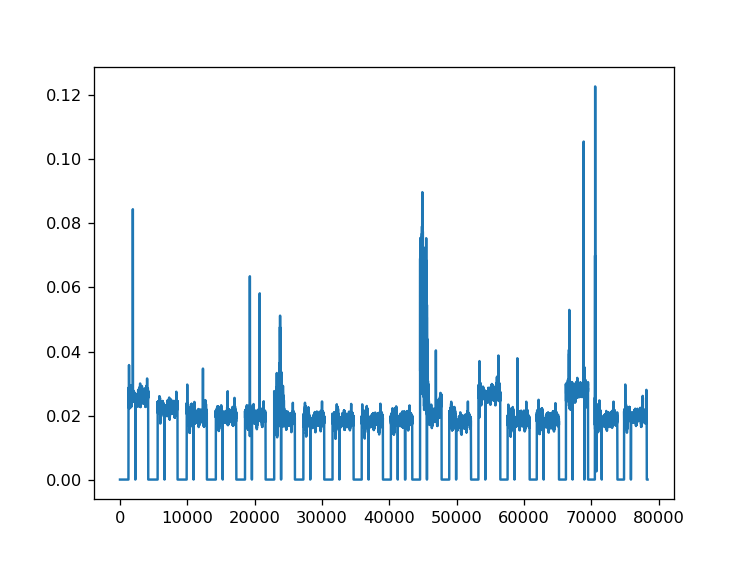

In [2]:
files = glob.glob('hera_idr2p1_gains/245*')
files.sort()

# Forgot to load this into file header
INT_TIME = 10.73741912841797

g = []; flags = []

for fn in files:
    with open(fn,'r') as fp:
        data = cp.load(fp)
    g.append(data['gains'])
    flags.append(data['flags'])
    
# Flags are 0 where there is data and 
# 1 where there is **no** data
flags = np.concatenate(np.concatenate(flags))
wgts = np.logical_not(flags)
g = np.concatenate(np.concatenate(g))

g = g * wgts

plt.figure()
plt.plot(np.abs(g))

# Single day gain variation

The above plot shows that the most of the variation is in small fringe-rates (long time periods) which is awesome because I can integrate on short scales without loss of information. Analysing a single day gain variation to confirm this.

### Antenna 23
### Chan 512 = 150MHz

In [3]:
def plot_ants(antpos):
    for k,v in antpos.items():
        plt.plot(v[0],v[1],'ko')
        plt.annotate('%d'%k,xy=(v[0],v[1]),xytext=(v[0]+.5,v[1]))

<IPython.core.display.Javascript object>


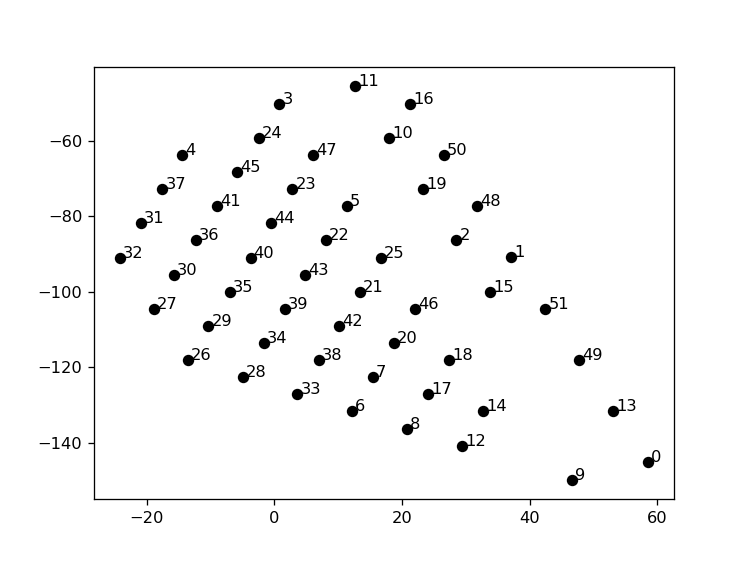

In [4]:
# Determine number of measurements = total number of baselines (including redundant)
with open('hera_idr2p1_gains/antpos_52ants.cp','r') as fp:
    antpos_52 = cp.load(fp)

redbls_52 = hera_cal.redcal.get_pos_reds(antpos_52)
allbls = [bl for red in redbls_52 for bl in red]

plt.figure()
plot_ants(antpos_52)

In [5]:
with open(files[1],'r') as fp:
    data = cp.load(fp)

/home/deepthi/anaconda3/envs/py27/lib/python2.7/site-packages/astropy/time/core.py:750: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif longitude == 'greenwich':


<IPython.core.display.Javascript object>


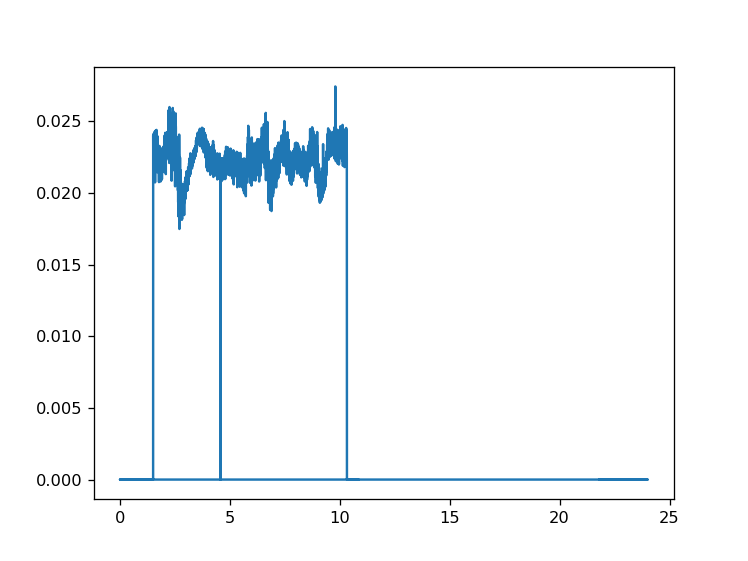

In [6]:
dflags = np.concatenate(data['flags'])
dgains = np.concatenate(data['gains'])

dwgts = np.logical_not(dflags)
dgains = dgains*dwgts

dtime = Time(np.concatenate(data['times']),format='jd') #np.arange(np.size(dgains))*INT_TIME
longitude = astropy.coordinates.Longitude(21.5,unit=u.deg)
lst = dtime.sidereal_time('mean',longitude=21.5*u.deg)

plt.figure()
plt.plot(lst.hour,np.abs(dgains))

<IPython.core.display.Javascript object>


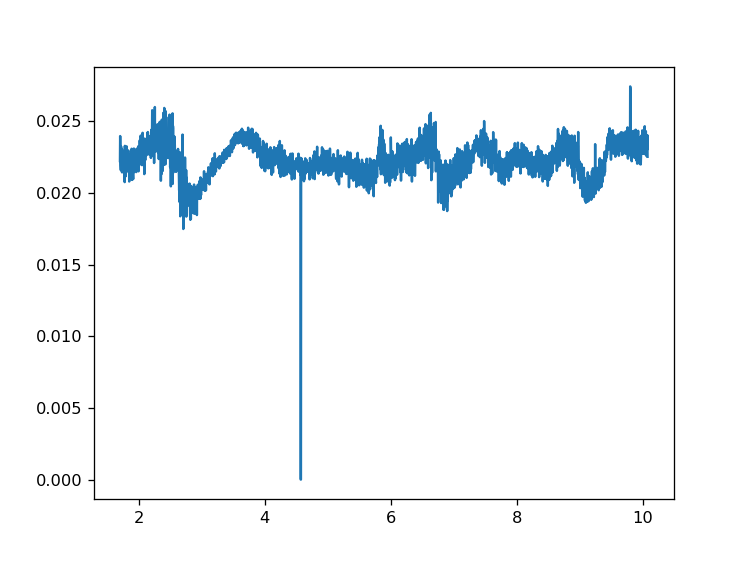

In [7]:
# Cut out flagged areas
dgains = dgains[1300:4100]
dwgts = dwgts[1300:4100]
dtime = dtime[1300:4100]
lst = dtime.sidereal_time('mean',longitude=21.5*u.deg)

plt.figure()
plt.plot(lst.hour, np.abs(dgains))

In [8]:
# Deconvolve to interpolate the single flagged value

Fdg = np.fft.ifft(dgains)
Fdker = np.fft.ifft(dwgts)

fringe_rate = np.fft.fftfreq(np.size(dtime),d=INT_TIME)

Fdg_deconv = aipy.deconv.clean(im = Fdg, ker = Fdker, tol=1e-6)

In [9]:
Fdg_deconv[1]

{'iter': 10000,
 'res': array([ 1.15126642e-05-4.78090164e-06j,  9.53710223e-06-8.57199339e-06j,
         2.30114296e-06+1.33140272e-05j, ...,
         1.15237720e-05+4.23843489e-06j,  7.34129724e-06+9.93598950e-06j,
        -1.11763260e-05-6.53824098e-06j]),
 'score': 1.1682065205404882e-05,
 'success': False,
 'term': 'maxiter',
 'tol': 1e-06}

<IPython.core.display.Javascript object>


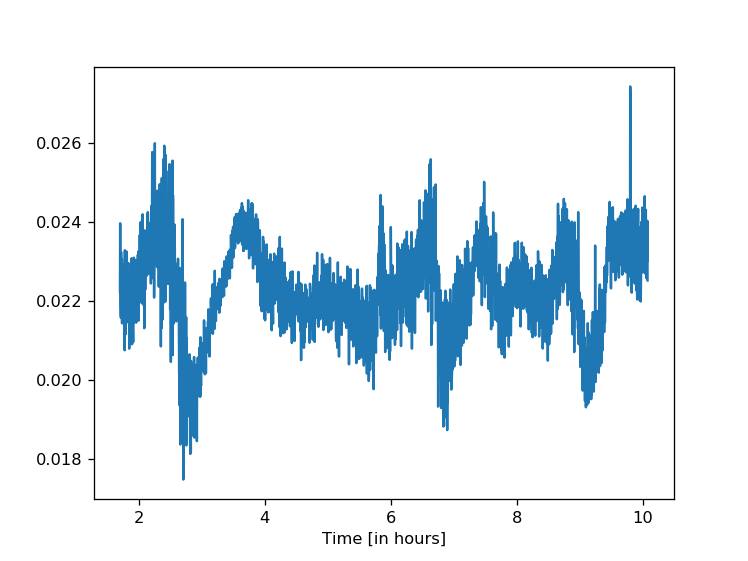

Text(0.5,0,'Time [in hours]')

In [10]:
# Interpolated and cleaned gains for a single day
gains_day = np.abs(np.fft.fft(Fdg_deconv[0] + Fdg_deconv[1]['res']))

# Check that the fourier transform converged
plt.figure()
plt.plot(lst.hour,gains_day)
#plt.plot(time_range/(60*60),np.abs(dgains),'--r',alpha=0.5)
plt.xlabel('Time [in hours]')

To understand how frequently you need to calibrate the gains:

1. Sample the gains at different time periods- different sampling frequencies will result in different 

In [11]:
gain_varfft = {}
for i in range(1,100,1):
    g = gains_day[::i]
    gain_varfft[(i,'freq')] = np.fft.fftfreq(len(g),d=i*INT_TIME)
    gain_varfft[(i,'ifft')] = np.fft.ifft(g)

<IPython.core.display.Javascript object>


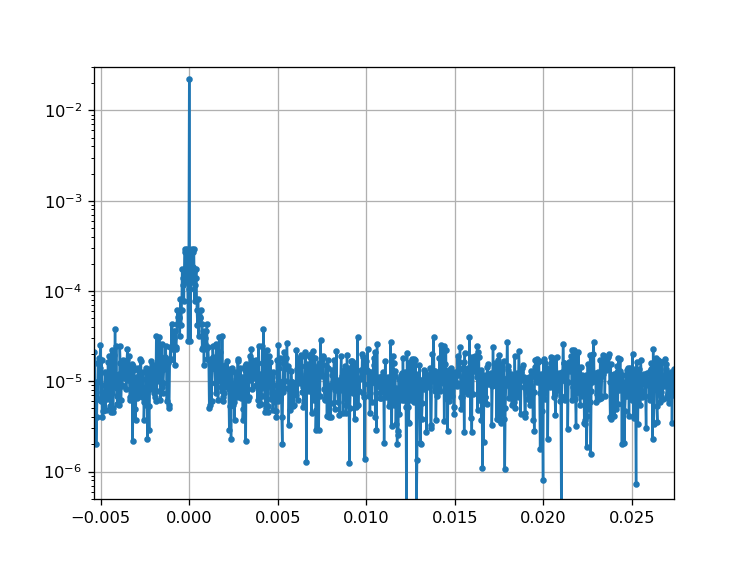

In [36]:
plt.figure()
plt.semilogy(np.fft.fftshift(gain_varfft[(1,'freq')]),np.fft.fftshift(np.abs(gain_varfft[(1,'ifft')])),'.-')

<IPython.core.display.Javascript object>


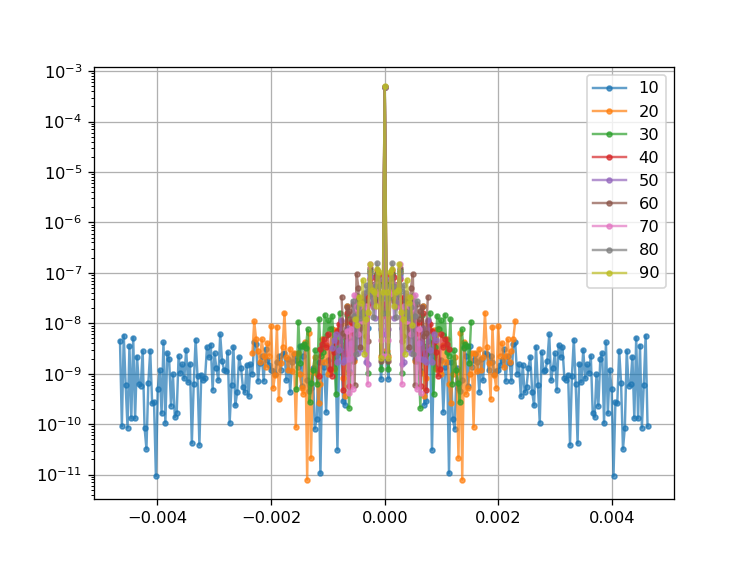

In [13]:
plt.figure()
for i in range(10,100,10):
    plt.plot(np.fft.fftshift(gain_varfft[(i,'freq')]),np.fft.fftshift(np.abs(gain_varfft[(i,'ifft')]))**2,'.-',label=i,alpha=0.7)
plt.legend()

In [14]:
def genA(redbls):
    # number of parameters = num_ants + num_unique baselines
    N = Nants + len(redbls)
    
    # number of measurements = total number of baselines
    allbls = [bl for red in redbls for bl in red]
    M = len(allbls)
    
    A = np.zeros([M,N],dtype=np.complex)
    i = 0
    for bl,reds in enumerate(redbls):
        for pair in reds:
            A[i,pair[0]] = (1+1j)
            A[i,pair[1]] = (1-1j)
            A[i,Nants+bl] = 1+1j
            i += 1
    return np.matrix(A)

In [16]:
Nants = 52
A = genA(redbls_52)
M,N = np.shape(A)
print M,N

1326 178


In [24]:
Mr = np.dot(np.real(A.T), np.real(A))
Mi = np.dot(np.imag(np.conjugate(A.T)), np.imag(A))

covr = np.linalg.pinv(Mr)[:Nants,:Nants]
covi = -1*np.linalg.pinv(Mi)[:Nants,:Nants]

In [25]:
var = np.diag(covr) + np.diag(covi)

In [35]:
Tsys = 500.
Tsrc = 5
B = 100e6/1024

noise = Tsys**2/((Tsrc**2)*2*B*INT_TIME) * var

In [34]:
np.sqrt(noise[23])

0.07053255967385413

In [33]:
gains_day

array([0.02223698, 0.02397716, 0.02266891, ..., 0.02314272, 0.02403946,
       0.02253088])

<IPython.core.display.Javascript object>


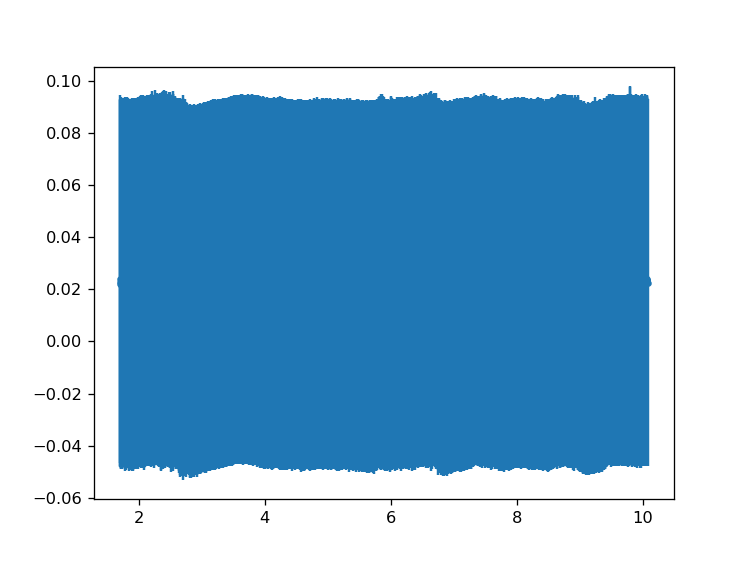

<ErrorbarContainer object of 3 artists>

In [31]:
plt.figure()

plt.errorbar(lst.hour, gains_day, yerr=np.sqrt(noise[23]), fmt='.')

<IPython.core.display.Javascript object>


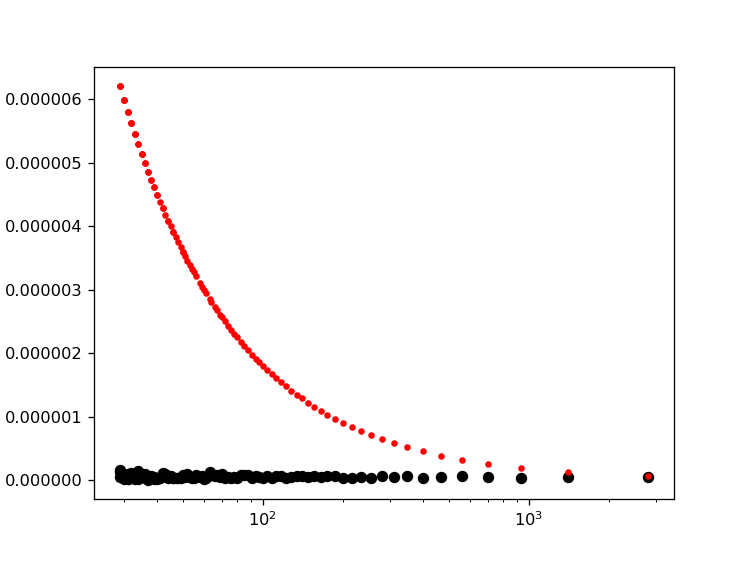

In [67]:
plt.figure()

Tsys = 500.      # Galactic + Receiver noise
Tsrc = 5.
B = 100e6/1024
Nmeas = len(allbls)
#noise = Tsys/(np.sqrt(len(Fdg_deconv[0])*INT_TIME*B*Nmeas))

for i in range(1,100,1):
    num = len(gain_varfft[(i,'ifft')])
    plt.semilogx(num, np.abs(gain_varfft[(i,'ifft')][3])**2,'ok',label=i)
    noise = Tsys/(np.sqrt(1326*INT_TIME*B*num))
    plt.semilogx(num, noise**2,'.r')
    #print i,num
    #plt.semilogx(num, 0.3e-2*np.sqrt(1.0/num),'.r')

In [20]:
Favg = np.abs(Fdg_deconv[0]+Fdg_deconv[1]['res'])**2
Favg = np.mean(Favg.reshape(-1,5),axis=1)
np.shape(Favg)

(560,)

In [27]:
def calib_coeff(antenna,redbls):
    #Number of times antenna is involved in that redundant set
    Na = np.array([l.count(antenna) for l in [[ant for pair in bls for ant in pair] for bls in redbls]])
    Nbl = np.array([len(bls) for bls in redbls])
    return np.sum(Nbl*Na)

In [30]:
calib_coeff(23,redbls_52)

1122

In [34]:
Tsys = 500.                       # Galactic + Receiver Noise
Tsrc = 5.                         # Expected EoR signal
Nm   = calib_coeff(23, redbls_52) # Number of measurements
B    = 100e6/1024

noise = Tsys/np.sqrt(Nm*B*INT_TIME)
print noise**2

0.00021249425969226596


<IPython.core.display.Javascript object>


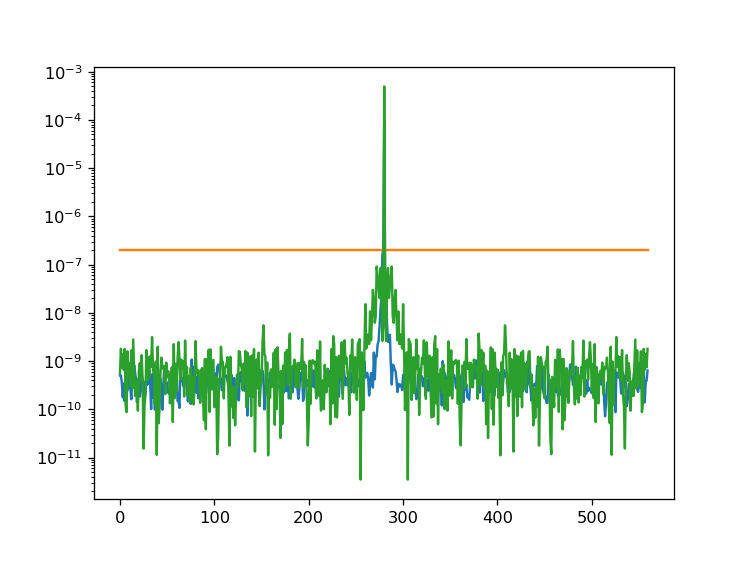

In [25]:
Tsys = 500.      # Galactic + Receiver noise
Tsrc = 5.
B = 250e6/8192
Nmeas = len(allbls)  # From the corresponding UVData (uvOCR) file = 1326

#noise = np.random.normal(loc=0,scale=Tsys/np.sqrt(B*time_range[1:]))
noise = Tsys/(np.sqrt(len(Fdg_deconv[0])*INT_TIME*B*Nmeas)) #np.sqrt(np.abs(fringe_rate)/B)
#np.sqrt(B*np.abs(fringe_rate))/Tsys

plt.figure()
plt.semilogy(np.fft.fftshift(Favg))
plt.semilogy(np.repeat(noise**2,len(Favg)))
plt.semilogy(np.fft.fftshift(np.abs(gain_varfft[(5,'ifft')]))**2)

In [ ]:
noise = Tsys/(np.sqrt(52*INT_TIME*B*350))
noise

In [ ]:
len(allbls)

In [ ]:
plt.figure()
plt.semilogy(fringe_rate,np.abs(Fdg_deconv[0]+Fdg_deconv[1]['res']),'.-')
plt.axvline(fringe_rate[-73],color='k',label='1min')
plt.axvline(fringe_rate[73],color='k')
plt.legend()

In [ ]:
Tsys = 500.
Tsrc = 5.
B = 250e6/4096

#noise = np.random.normal(loc=0,scale=Tsys/np.sqrt(B*time_range[1:]))
noise = Tsys/(np.sqrt(Nbls*(4100-1300)*INT_TIME*B)) #np.sqrt(np.abs(fringe_rate)/B)
#np.sqrt(B*np.abs(fringe_rate))/Tsys

plt.figure()
plt.semilogy(fringe_rate,np.abs(Fdg_deconv[0]+Fdg_deconv[1]['res']),'.-')
plt.axvline(fringe_rate[-73],color='k',label='1min')
plt.axvline(fringe_rate[73],color='k')
plt.semilogy(fringe_rate,np.repeat(noise,len(fringe_rate)))
#plt.plot(fringe_rate, np.abs(np.fft.fft(noise)))

# Integration time

In [ ]:
Tsys = 500
Tsrc = 5
B = 250e6/4096

Sr_inv = np.asarray([s**-1 if s>10**-11 else 0 for s in Sr])
Si_inv = np.asarray([s**-1 if s>10**-11 else 0 for s in Si])

tr = Tsys**2/(B*Tsrc**2)*Sr_inv
ti = Tsys**2/(B*Tsrc**2)*Si_inv

plt.plot(tr,'o-',label='Real')
plt.plot(ti,'o-',label='Imag')
plt.legend()
plt.show()